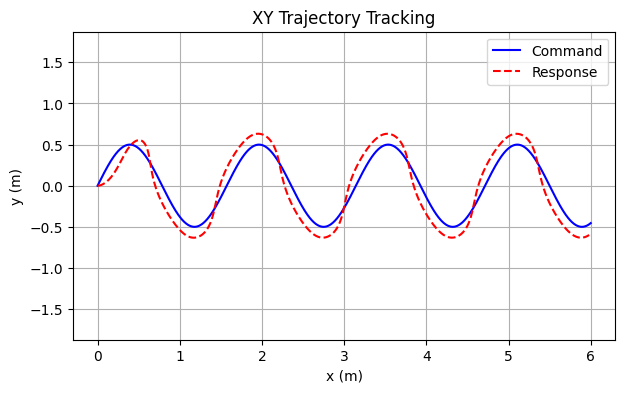

In [4]:
"""
Differential-Drive Robot – Jacobian-Based Cartesian Feedback Control
---------------------------------------------------------------------

Author: Dr. Harsha Abeykoon
Embry-Riddle Aeronautical University

This Python script implements the full closed-loop controller described in the
accompanying PDF document on Jacobian-based Cartesian control for a differential-
drive robot. The method treats the differential-drive platform like a 2-DOF planar
manipulator and computes wheel accelerations using the Jacobian pseudoinverse.

The simulation follows the exact block structure and equations described in the
document:

    • PD control in Cartesian space (Section 4.1)
    • Integration to obtain desired velocities (Section 4.2)
    • Inverse kinematics via pseudoinverse J⁺ (Eq. 16)
    • Forward kinematics using the Jacobian (Eq. 13)
    • Dead-reckoning integration (Section 4.6)
    • Full closed-loop architecture (Fig. 2)

Pipeline implemented here:

1. Compute errors in (x, y, phi) using commanded trajectory.
2. Use PD control to compute desired accelerations ddx, ddy, ddphi.
3. Convert desired accelerations to wheel accelerations using J⁺.
4. Integrate to obtain wheel velocities and wheel angles.
5. Use forward kinematics to compute actual dx, dy, dphi.
6. Integrate robot state to update (x_res, y_res, phi_res).
7. Plot commanded vs. actual trajectory.

The robot follows a sinusoidal Cartesian path:
        x(t) = v t
        y(t) = A sin(k x)

Feel free to tune kp, kv, A, v, and k to explore controller behavior.
"""




import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
# PARAMETERS
# ----------------------------------------
T  = 30.0          # total time (s)
Ts = 0.01          # sampling time (s)

A = 0.5            # amplitude of sinusoid (m)
v = 0.2            # forward speed (m/s)
k = 4.0            # spatial frequency

R = 0.02           # wheel radius (m)
W = 0.127          # wheel separation (m)

kp = 5.0           # PD gains (you can tune)
kv = 2.0

# ----------------------------------------
# TIME
# ----------------------------------------
t = np.arange(0, T, Ts)
N = len(t)

# ----------------------------------------
# COMMAND TRAJECTORY (same as before)
# ----------------------------------------
x_com   = v * t
y_com   = A * np.sin(k * x_com)

x_dot_c = v * np.ones(N)
y_dot_c = A * k * v * np.cos(k * x_com)

phi_com = np.arctan2(y_dot_c, x_dot_c)
phi_dot_c = np.zeros(N)
phi_dot_c[1:] = (phi_com[1:] - phi_com[:-1]) / Ts

# ----------------------------------------
# RESPONSE ARRAYS
# ----------------------------------------
x_res   = np.zeros(N)
y_res   = np.zeros(N)
phi_res = np.zeros(N)

dx_res   = np.zeros(N)
dy_res   = np.zeros(N)
dphi_res = np.zeros(N)

# wheel states (RIGHT then LEFT to match eqns!)
theta_r = 0.0
theta_l = 0.0
theta_dot_r = 0.0
theta_dot_l = 0.0

# ----------------------------------------
# MAIN SIMULATION LOOP
# ----------------------------------------
for i in range(N - 1):

    # -------------------- errors --------------------
    ex   = x_com[i]   - x_res[i]
    ey   = y_com[i]   - y_res[i]
    ephi = phi_com[i] - phi_res[i]
    ephi = np.arctan2(np.sin(ephi), np.cos(ephi))   # wrap to [-pi, pi]

    ex_dot   = x_dot_c[i]   - dx_res[i]
    ey_dot   = y_dot_c[i]   - dy_res[i]
    ephi_dot = phi_dot_c[i] - dphi_res[i]

    # ---------------- PD in Cartesian space ---------
    ddx   = kp * ex   + kv * ex_dot
    ddy   = kp * ey   + kv * ey_dot
    ddphi = kp * ephi + kv * ephi_dot

    # ---------------- Eq. (16): J+ * ddX ------------
    phi = phi_res[i]

    ddtheta_r = ( np.cos(phi)*ddx + np.sin(phi)*ddy + (W/2.0)*ddphi ) / R
    ddtheta_l = ( np.cos(phi)*ddx + np.sin(phi)*ddy - (W/2.0)*ddphi ) / R

    # integrate wheel speeds (assume perfect wheel PID)
    theta_dot_r += ddtheta_r * Ts
    theta_dot_l += ddtheta_l * Ts

    theta_r += theta_dot_r * Ts
    theta_l += theta_dot_l * Ts

    # ---------------- Eq. (13): forward Jacobian ----
    v_forward = (R / 2.0) * (theta_dot_r + theta_dot_l)

    dx   = v_forward * np.cos(phi)
    dy   = v_forward * np.sin(phi)
    dphi = (R / W) * (theta_dot_r - theta_dot_l)

    dx_res[i+1]   = dx
    dy_res[i+1]   = dy
    dphi_res[i+1] = dphi

    # ---------------- dead-reckoning ----------------
    x_res[i+1] = x_res[i] + dx * Ts
    y_res[i+1] = y_res[i] + dy * Ts
    phi_res[i+1] = phi_res[i] + dphi * Ts
    phi_res[i+1] = np.arctan2(np.sin(phi_res[i+1]), np.cos(phi_res[i+1]))

# ----------------------------------------
# PLOT XY COMMAND VS RESPONSE
# ----------------------------------------
plt.figure(figsize=(7, 4))
plt.plot(x_com, y_com, 'b', label='Command')
plt.plot(x_res, y_res, 'r--', label='Response')
plt.title('XY Trajectory Tracking')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()
